In [209]:
# Group Assignment 2
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import math

# Stock and variable information
S0 = 100
v0 = 0.06
kappa = 9
theta = 0.06
r = 0.08
sigma = 0.3
rho = -0.4
gamma = 0.75

# Strike info
K = 100
T = 1
k_log = np.log(K)

t_max = 30
N = 100


In [210]:
a = sigma**2/2

# Functions for use in the Heston model calculation for Call price

def b(u):
    return kappa - rho * sigma * 1j * u

def c(u):
    return -(u ** 2 + u * 1j) / 2

def d(u):
    return np.sqrt(b(u) ** 2 - 4 * a *c(u))

def xminus(u):
    return (b(u) - d(u)) / (2 * a)

def xplus(u):
    return (b(u) + d(u)) / (2 * a)

def g(u):
    return xminus(u) / xplus(u)

In [211]:
def C(u):
    val = T * xminus(u) - np.log((1 - g(u) * np.exp(-T * d(u))) / (1 - g(u))) / a
    return r * T * 1j * u + theta * kappa * val

def D(u):
    val1 = 1 - np.exp(-T * d(u))
    val2 = 1 - g(u) * np.exp(-T * d(u))
    return (val1/val2) * xminus(u)

def log_char(u):
    return np.exp(C(u) + D(u) * v0 + 1j * u * np.log(S0))

def adj_char(u):
    return log_char(u - 1j) / log_char(-1j)


In [212]:
# Variables to vectorize the code - creating time samples
delta_t = t_max/N
from_1_to_N = np.linspace(1,N,N)
t_n = (from_1_to_N-1/2)*delta_t

# Approximate integral estimates and Fourier call price estimate
first_integral = sum((((np.exp(-1j * t_n * k_log) * adj_char(t_n)).imag) / t_n) * delta_t)
second_integral = sum((((np.exp(-1j * t_n * k_log) * log_char(t_n)).imag) / t_n) * delta_t)
fourier_cp = S0 * (1/2 + first_integral/np.pi) - K * np.exp(-r * T) * (1/2 + second_integral/np.pi)
print("Fourier Call Price : {}".format(fourier_cp))

Fourier Call Price : 13.734895692109077


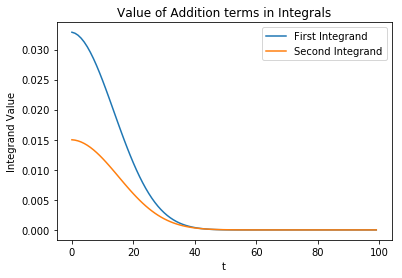

In [213]:
plt.plot(((((np.exp(-1j*t_n*k_log)*adj_char(t_n)).imag)/t_n)*delta_t),label = "First Integrand")
plt.plot(((((np.exp(-1j*t_n*k_log)*log_char(t_n)).imag)/t_n)*delta_t),label = "Second Integrand")
plt.title("Value of Addition terms in Integrals")
plt.xlabel("t")
plt.ylabel("Integrand Value")
plt.legend()
plt.show()

In [214]:
# Time periods of monthly intervals, 1/12
def find_terminal_price(S0,r,Z,gamma,sigma):
    for i in range(0,12):
        sigma = sigma * S0 ** (gamma - 1)
        S0 = S0 * np.exp((r - sigma**2/2)*(1/12) + sigma*np.sqrt(1/12)*Z)
    return S0

In [215]:
# Calculate Discounted Payoff 
def discounted_payoff(S,K,r,T):
    return np.maximum(S-K,0) * np.exp(-r * T)

In [216]:
# Monteo Carlo simulation
mcall_est = [None]*50
mcall_std = [None]*50
for i in range(1,51):
    Z = norm.rvs(size = 1000*i)
    term_val = find_terminal_price(S0, r, Z, gamma, sigma)
    mcall_val = discounted_payoff(term_val,K,r,T)
    mcall_est[i-1] = np.mean(mcall_val)
    mcall_std[i-1] = np.std(mcall_val) / np.sqrt(i*1000)

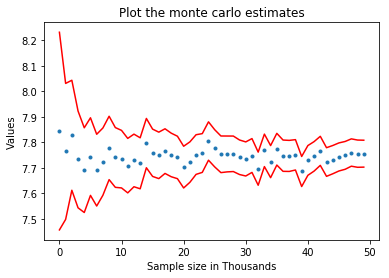

In [217]:
# Plotting the graphs
plt.title("Plot the monte carlo estimates")
plt.plot(mcall_est,'.')
plt.plot(mcall_est + 3 * np.array(mcall_std),'r')
plt.plot(mcall_est - 3 * np.array(mcall_std),'r')
plt.xlabel('Sample size in Thousands')
plt.ylabel('Values')
plt.show()

In [229]:
sigma_bs = np.sqrt(v0)
d1 = (np.log(S0/K) + (r + sigma_bs ** 2/2) * T) / (sigma_bs * np.sqrt(T))
d2 = d1 - sigma_bs * np.sqrt(T)
bs_call = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
print("Black Scholes Price (sigma = sqrt(v0)) : {}".format(bs_call))
print("Heston Model Fourier Price : {}".format(fourier_cp))
print("Error : {}".format(fourier_cp - bs_call))

Black Scholes Price (sigma = sqrt(v0)) : 13.709833079020868
Heston Model Fourier Price : 13.734895692109077
Error : 0.025062613088209673
